# **Gaussian Process Experiment (Same Seed Scenario)**
This notebook computes the Adapted Wasserstein Distance (AW) between two Gaussian processes over a 4-dimensional space (`T = 4`) using the same seed for path generation. 

The objective is to study the impact of using the same seed vs not the same seed on the estimation of the AWD.

## Imports and Setup

In [1]:
import os, sys, numpy as np, time, random
import matplotlib.pyplot as plt

notebooks_path = os.path.abspath(os.getcwd())
src_path = os.path.abspath(os.path.join(notebooks_path, "../src"))
if src_path not in sys.path:
    sys.path.insert(0, src_path)

from optimal_code.utils import *
from optimal_code.optimal_solver import *
from adapted_empirical_measure.AEM_grid import *

## Experiment Parameters

In [2]:
sample_sizes = [1000, 2000, 4000, 6000, 8000, 10000, 12000, 14000, 15000, 16000]
fixed_grid = 0.1
n_runs = 10

# Define matrices (dimension 4)
L = np.array([[1, 0, 0, 0],
              [1, 2, 0, 0],
              [1, 2, 3, 0],
              [1, 2, 3, 4]])

M = np.array([[1, 0, 0, 0],
              [2, 1, 0, 0],
              [3, 2, 1, 0],
              [4, 3, 2, 1]])

## Running Experiments

In [3]:
results = {}  # Dictionary to store results keyed by sample size

for n_sample in sample_sizes:
    distances_runs = np.zeros(n_runs)
    times_runs = np.zeros(n_runs)
    
    print(f"\nRunning experiments for sample size: {n_sample}")
    
    for run in range(n_runs):
        seed1 = np.random.randint(10000)  # Using same seed for both matrices
        
        # Generate sample paths
        X, A = Lmatrix2paths(L, n_sample, seed=seed1, verbose=False)
        Y, B = Lmatrix2paths(M, n_sample, seed=seed1, verbose=False)

        # Compute the theoretical benchmark distance
        benchmark = adapted_wasserstein_squared(A, B)

        # Convert paths to adapted versions using the fixed grid
        adaptedX = path2adaptedpath(X, delta_n=fixed_grid)
        adaptedY = path2adaptedpath(Y, delta_n=fixed_grid)

        # Build quantization mapping
        q2v = np.unique(np.concatenate([adaptedX, adaptedY], axis=0))
        v2q = {k: v for v, k in enumerate(q2v)}

        # Quantize paths
        qX = np.array([[v2q[x] for x in y] for y in adaptedX])
        qY = np.array([[v2q[x] for x in y] for y in adaptedY])

        # Sort the quantized paths
        qX = sort_qpath(qX.T)
        qY = sort_qpath(qY.T)

        # Build conditional distributions
        mu_x = qpath2mu_x(qX)
        nu_y = qpath2mu_x(qY)
        mu_x_c, mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn = list_repr_mu_x(mu_x, q2v)
        nu_y_c, nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn = list_repr_mu_x(nu_y, q2v)

        # Compute the numerical AWD
        t_start = time.perf_counter()
        AW_2square = nested2_parallel(mu_x_cn, mu_x_v, mu_x_w, mu_x_cumn,
                                      nu_y_cn, nu_y_v, nu_y_w, nu_y_cumn,
                                      n_processes=42)
        elapsed = time.perf_counter() - t_start

        distances_runs[run] = AW_2square
        times_runs[run] = elapsed
        
        print(f"Sample size {n_sample}, Run {run+1}: AW_2^2 = {AW_2square:.4f}, Time = {elapsed:.4f} s")

    # Store results for the current sample size
    results[n_sample] = {"distances": distances_runs,
                         "times": times_runs,
                         "benchmark": benchmark}


Running experiments for sample size: 1000


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 193.50it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 210.17it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 197.11it/s]

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 109.89it/s]

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 108.12it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 54.45it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 86.23it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 91.87it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 458.74it/s]


Sample size 1000, Run 1: AW_2^2 = 28.9744, Time = 3.5869 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 186.67it/s]


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 210.23it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 201.51it/s]

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 169.24it/s]

100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 67.87it/s]

100%|██████████████████████████████████████████| 19/19 [00:00<00:00, 200.06it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 65.88it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 436.86it/s]


Sample size 1000, Run 2: AW_2^2 = 27.9631, Time = 3.4845 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 157.14it/s]

  0%|                                                    | 0/24 [00:00<?, ?it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 202.53it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 210.63it/s]

100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 73.14it/s]

100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 85.86it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 748.72it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 86.72it/s]

  0%|                                                     | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 419.30it/s]


Sample size 1000, Run 3: AW_2^2 = 26.3829, Time = 3.4136 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 208.22it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 208.51it/s]

100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 81.75it/s]

100%|██████████████████████████████████████████| 20/20 [00:00<00:00, 121.16it/s]

100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 46.36it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 71.59it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 53.32it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 66.78it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 407.49it/s]


Sample size 1000, Run 4: AW_2^2 = 28.6792, Time = 3.4863 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 200.75it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 197.21it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 174.61it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 192.61it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 197.21it/s]

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 69.33it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 76.49it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1275.64it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 94.16it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 343.82it/s]


Sample size 1000, Run 5: AW_2^2 = 28.9263, Time = 3.5802 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 209.27it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 207.68it/s]

100%|███████████████████████████████████████████| 19/19 [00:00<00:00, 94.09it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 86.90it/s]

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 76.00it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 437.32it/s]


Sample size 1000, Run 6: AW_2^2 = 28.2467, Time = 3.4578 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 196.46it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 177.28it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 209.67it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 193.12it/s]

100%|██████████████████████████████████████████| 23/23 [00:00<00:00, 198.77it/s]

100%|██████████████████████████████████████████| 19/19 [00:00<00:00, 170.26it/s]

100%|██████████████████████████████████████████| 19/19 [00:00<00:00, 196.23it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 55.74it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 344.53it/s]


Sample size 1000, Run 7: AW_2^2 = 28.4634, Time = 3.4699 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 192.67it/s]

  0%|                                                     | 0/2 [00:00<?, ?it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 79.87it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 54.64it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 418.13it/s]


Sample size 1000, Run 8: AW_2^2 = 28.1961, Time = 3.4824 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 208.75it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 206.77it/s]

 65%|███████████████████████████▎              | 13/20 [00:00<00:00, 125.36it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 71.07it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 53.73it/s]

100%|███████████████████████████████████████████| 1/1 [00:00<00:00, 1231.45it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 57.84it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 459.80it/s]


Sample size 1000, Run 9: AW_2^2 = 28.6348, Time = 3.6001 s


100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 208.88it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 192.65it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 209.17it/s]

100%|██████████████████████████████████████████| 24/24 [00:00<00:00, 182.84it/s]

100%|███████████████████████████████████████████| 20/20 [00:00<00:00, 71.44it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 54.30it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 78.60it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 57.10it/s]


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 418.51it/s]


Sample size 1000, Run 10: AW_2^2 = 27.0704, Time = 3.3340 s

Running experiments for sample size: 2000


100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 85.81it/s]

100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 87.82it/s]

 41%|█████████████████▋                         | 14/34 [00:00<00:01, 17.27it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 52.66it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 53.94it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 382.48it/s]


Sample size 2000, Run 1: AW_2^2 = 29.2526, Time = 7.3465 s


100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 100.66it/s]

100%|███████████████████████████████████████████| 33/33 [00:01<00:00, 24.78it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 951.31it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 404.66it/s]


Sample size 2000, Run 2: AW_2^2 = 27.6005, Time = 7.3592 s


 64%|███████████████████████████▍               | 30/47 [00:00<00:00, 95.32it/s]

100%|███████████████████████████████████████████| 47/47 [00:00<00:00, 99.62it/s]

100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 102.21it/s]

100%|███████████████████████████████████████████| 33/33 [00:00<00:00, 35.40it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 81.74it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 382.62it/s]


Sample size 2000, Run 3: AW_2^2 = 28.2348, Time = 7.1903 s


 92%|██████████████████████████████████████▌   | 44/48 [00:00<00:00, 104.04it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 545.64it/s]


Sample size 2000, Run 4: AW_2^2 = 27.9154, Time = 7.0526 s


100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 100.40it/s]

100%|███████████████████████████████████████████| 34/34 [00:01<00:00, 23.35it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 346.24it/s]


Sample size 2000, Run 5: AW_2^2 = 28.6581, Time = 7.4172 s


100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 104.17it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 52.71it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 338.93it/s]


Sample size 2000, Run 6: AW_2^2 = 27.0785, Time = 7.7718 s


 90%|█████████████████████████████████████▋    | 43/48 [00:00<00:00, 101.76it/s]

100%|███████████████████████████████████████████| 47/47 [00:00<00:00, 93.90it/s]

100%|███████████████████████████████████████████| 47/47 [00:00<00:00, 88.24it/s]

100%|███████████████████████████████████████████| 47/47 [00:00<00:00, 89.47it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 77.77it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 421.88it/s]


Sample size 2000, Run 7: AW_2^2 = 28.8619, Time = 7.6876 s


 21%|█████████▏                                 | 10/47 [00:00<00:00, 99.86it/s]

100%|██████████████████████████████████████████| 47/47 [00:00<00:00, 100.78it/s]

100%|███████████████████████████████████████████| 47/47 [00:00<00:00, 96.56it/s]

100%|███████████████████████████████████████████| 47/47 [00:00<00:00, 96.78it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 319.01it/s]


Sample size 2000, Run 8: AW_2^2 = 28.7752, Time = 7.2445 s


100%|██████████████████████████████████████████| 48/48 [00:00<00:00, 103.21it/s]

100%|█████████████████████████████████████████████| 2/2 [00:00<00:00, 47.61it/s]

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 66.40it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 386.14it/s]


Sample size 2000, Run 9: AW_2^2 = 29.3415, Time = 7.5398 s


 92%|██████████████████████████████████████▌   | 44/48 [00:00<00:00, 100.50it/s]

100%|███████████████████████████████████████████| 48/48 [00:00<00:00, 98.48it/s]

100%|███████████████████████████████████████████| 35/35 [00:01<00:00, 33.17it/s]

 18%|███████▊                                    | 6/34 [00:00<00:02, 13.51it/s]

100%|███████████████████████████████████████████| 34/34 [00:00<00:00, 63.70it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 578.44it/s]


Sample size 2000, Run 10: AW_2^2 = 30.2038, Time = 7.9149 s

Running experiments for sample size: 4000


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 587.93it/s]


Sample size 4000, Run 1: AW_2^2 = 28.3763, Time = 17.9668 s


 29%|████████████▎                              | 27/94 [00:00<00:01, 42.30it/s]

100%|███████████████████████████████████████████| 95/95 [00:01<00:00, 48.51it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 385.93it/s]


Sample size 4000, Run 2: AW_2^2 = 29.3917, Time = 20.1925 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 443.84it/s]


Sample size 4000, Run 3: AW_2^2 = 29.1492, Time = 19.4645 s


100%|███████████████████████████████████████████| 94/94 [00:02<00:00, 46.29it/s]

100%|███████████████████████████████████████████| 53/53 [00:06<00:00,  8.29it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 298.78it/s]


Sample size 4000, Run 4: AW_2^2 = 30.2769, Time = 20.3411 s


 68%|█████████████████████████████▎             | 64/94 [00:01<00:00, 44.78it/s]

100%|███████████████████████████████████████████| 95/95 [00:02<00:00, 46.30it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 317.51it/s]


Sample size 4000, Run 5: AW_2^2 = 29.9277, Time = 20.2896 s


100%|███████████████████████████████████████████| 95/95 [00:02<00:00, 45.73it/s]

100%|███████████████████████████████████████████| 95/95 [00:02<00:00, 47.05it/s]

100%|███████████████████████████████████████████| 94/94 [00:02<00:00, 46.60it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 356.54it/s]


Sample size 4000, Run 6: AW_2^2 = 30.0776, Time = 20.8806 s


100%|███████████████████████████████████████████| 94/94 [00:02<00:00, 45.77it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 305.37it/s]


Sample size 4000, Run 7: AW_2^2 = 29.8256, Time = 20.3595 s


 92%|███████████████████████████████████████▍   | 87/95 [00:01<00:00, 42.82it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 405.56it/s]


Sample size 4000, Run 8: AW_2^2 = 29.2917, Time = 18.8495 s


100%|███████████████████████████████████████████| 94/94 [00:02<00:00, 45.34it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 347.64it/s]


Sample size 4000, Run 9: AW_2^2 = 28.9970, Time = 19.9018 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 510.01it/s]


Sample size 4000, Run 10: AW_2^2 = 29.2458, Time = 20.6741 s

Running experiments for sample size: 6000


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 435.68it/s]


Sample size 6000, Run 1: AW_2^2 = 29.6004, Time = 34.7455 s


100%|█████████████████████████████████████████| 141/141 [00:04<00:00, 31.55it/s]

100%|███████████████████████████████████████████| 64/64 [00:10<00:00,  5.82it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 503.34it/s]


Sample size 6000, Run 2: AW_2^2 = 30.0851, Time = 35.5061 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 397.90it/s]


Sample size 6000, Run 3: AW_2^2 = 30.0161, Time = 34.5855 s


100%|█████████████████████████████████████████| 142/142 [00:05<00:00, 27.86it/s]

100%|█████████████████████████████████████████| 141/141 [00:04<00:00, 28.99it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 358.24it/s]


Sample size 6000, Run 4: AW_2^2 = 30.3149, Time = 36.2910 s


100%|█████████████████████████████████████████| 141/141 [00:04<00:00, 30.43it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 383.50it/s]


Sample size 6000, Run 5: AW_2^2 = 30.0629, Time = 35.5362 s


100%|█████████████████████████████████████████| 142/142 [00:04<00:00, 32.93it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 511.31it/s]


Sample size 6000, Run 6: AW_2^2 = 29.3214, Time = 35.1927 s


100%|█████████████████████████████████████████| 141/141 [00:04<00:00, 30.26it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 348.16it/s]


Sample size 6000, Run 7: AW_2^2 = 29.9285, Time = 35.9725 s


100%|█████████████████████████████████████████| 141/141 [00:04<00:00, 29.60it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 531.19it/s]


Sample size 6000, Run 8: AW_2^2 = 29.6327, Time = 36.1271 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 361.95it/s]


Sample size 6000, Run 9: AW_2^2 = 29.9830, Time = 33.2035 s


 70%|█████████████████████████████▏            | 98/141 [00:03<00:01, 28.54it/s]

100%|█████████████████████████████████████████| 141/141 [00:04<00:00, 30.90it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 372.53it/s]


Sample size 6000, Run 10: AW_2^2 = 29.7196, Time = 35.0066 s

Running experiments for sample size: 8000


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 346.98it/s]


Sample size 8000, Run 1: AW_2^2 = 30.1811, Time = 54.7274 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 359.47it/s]


Sample size 8000, Run 2: AW_2^2 = 29.4965, Time = 53.1139 s


100%|█████████████████████████████████████████| 188/188 [00:08<00:00, 22.59it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 335.36it/s]


Sample size 8000, Run 3: AW_2^2 = 30.0901, Time = 56.1117 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 387.61it/s]


Sample size 8000, Run 4: AW_2^2 = 29.9145, Time = 52.2208 s


 90%|██████████████████████████████████████▊    | 65/72 [00:12<00:00, 10.45it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 510.13it/s]


Sample size 8000, Run 5: AW_2^2 = 29.8852, Time = 53.3209 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 362.89it/s]


Sample size 8000, Run 6: AW_2^2 = 29.9280, Time = 53.4097 s


100%|█████████████████████████████████████████| 188/188 [00:08<00:00, 23.13it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 362.36it/s]


Sample size 8000, Run 7: AW_2^2 = 30.0329, Time = 56.2398 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 541.20it/s]


Sample size 8000, Run 8: AW_2^2 = 30.2750, Time = 54.7900 s


 77%|███████████████████████████████▌         | 144/187 [00:06<00:01, 24.08it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 464.59it/s]


Sample size 8000, Run 9: AW_2^2 = 29.8161, Time = 56.2689 s


 91%|█████████████████████████████████████▎   | 171/188 [00:07<00:00, 24.73it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 533.76it/s]


Sample size 8000, Run 10: AW_2^2 = 29.7208, Time = 53.1474 s

Running experiments for sample size: 10000


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 378.89it/s]


Sample size 10000, Run 1: AW_2^2 = 29.7361, Time = 74.4781 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 493.22it/s]


Sample size 10000, Run 2: AW_2^2 = 29.8665, Time = 76.9193 s


 73%|██████████████████████████████           | 171/233 [00:10<00:03, 16.81it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 338.88it/s]


Sample size 10000, Run 3: AW_2^2 = 29.9948, Time = 73.4560 s


100%|█████████████████████████████████████████| 233/233 [00:13<00:00, 22.25it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 530.66it/s]


Sample size 10000, Run 4: AW_2^2 = 30.7263, Time = 76.0717 s


100%|█████████████████████████████████████████| 233/233 [00:14<00:00, 16.51it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 419.60it/s]


Sample size 10000, Run 5: AW_2^2 = 29.2800, Time = 76.4519 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 510.94it/s]


Sample size 10000, Run 6: AW_2^2 = 30.1973, Time = 73.8557 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 534.58it/s]


Sample size 10000, Run 7: AW_2^2 = 30.4497, Time = 76.1651 s


100%|█████████████████████████████████████████| 234/234 [00:13<00:00, 17.45it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 358.76it/s]


Sample size 10000, Run 8: AW_2^2 = 30.0300, Time = 71.3871 s


100%|█████████████████████████████████████████| 235/235 [00:14<00:00, 16.64it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 336.65it/s]


Sample size 10000, Run 9: AW_2^2 = 29.6392, Time = 74.2337 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 349.82it/s]


Sample size 10000, Run 10: AW_2^2 = 29.2869, Time = 70.4981 s

Running experiments for sample size: 12000


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 340.83it/s]


Sample size 12000, Run 1: AW_2^2 = 29.7491, Time = 94.0369 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 353.83it/s]


Sample size 12000, Run 2: AW_2^2 = 30.3854, Time = 98.4979 s


100%|█████████████████████████████████████████| 279/279 [00:19<00:00, 14.39it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 266.10it/s]


Sample size 12000, Run 3: AW_2^2 = 30.1721, Time = 97.0903 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 367.89it/s]


Sample size 12000, Run 4: AW_2^2 = 30.9246, Time = 104.5436 s


100%|█████████████████████████████████████████| 280/280 [00:19<00:00, 14.54it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 534.71it/s]


Sample size 12000, Run 5: AW_2^2 = 30.0972, Time = 97.2526 s


100%|███████████████████████████████████████████| 85/85 [00:19<00:00,  4.26it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 251.86it/s]


Sample size 12000, Run 6: AW_2^2 = 30.5653, Time = 97.0761 s


100%|█████████████████████████████████████████| 279/279 [00:19<00:00, 14.28it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 341.42it/s]


Sample size 12000, Run 7: AW_2^2 = 30.3478, Time = 92.0888 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 280.14it/s]


Sample size 12000, Run 8: AW_2^2 = 30.8772, Time = 105.3812 s


100%|█████████████████████████████████████████| 279/279 [00:19<00:00, 14.61it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 308.38it/s]


Sample size 12000, Run 9: AW_2^2 = 30.6278, Time = 96.3044 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 367.34it/s]


Sample size 12000, Run 10: AW_2^2 = 30.1142, Time = 96.5281 s

Running experiments for sample size: 14000


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 352.97it/s]


Sample size 14000, Run 1: AW_2^2 = 30.1459, Time = 125.3464 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 498.55it/s]


Sample size 14000, Run 2: AW_2^2 = 30.5284, Time = 120.1230 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 264.91it/s]


Sample size 14000, Run 3: AW_2^2 = 30.7629, Time = 118.8288 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 333.78it/s]


Sample size 14000, Run 4: AW_2^2 = 30.3561, Time = 119.4115 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 346.49it/s]


Sample size 14000, Run 5: AW_2^2 = 30.6469, Time = 122.2676 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 351.81it/s]


Sample size 14000, Run 6: AW_2^2 = 29.9036, Time = 123.4692 s


100%|█████████████████████████████████████████| 325/325 [00:26<00:00, 12.04it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 462.34it/s]


Sample size 14000, Run 7: AW_2^2 = 30.6148, Time = 119.5599 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 394.09it/s]


Sample size 14000, Run 8: AW_2^2 = 29.7172, Time = 118.0691 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 377.87it/s]


Sample size 14000, Run 9: AW_2^2 = 30.6393, Time = 121.1084 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 356.51it/s]


Sample size 14000, Run 10: AW_2^2 = 29.4191, Time = 129.0772 s

Running experiments for sample size: 15000


 94%|██████████████████████████████████████▍  | 325/347 [00:29<00:01, 13.29it/s]

100%|█████████████████████████████████████████| 348/348 [00:31<00:00, 11.21it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 369.18it/s]


Sample size 15000, Run 1: AW_2^2 = 30.2354, Time = 128.1152 s


100%|█████████████████████████████████████████| 347/347 [00:29<00:00, 11.70it/s]

100%|█████████████████████████████████████████| 347/347 [00:29<00:00, 11.60it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 482.99it/s]


Sample size 15000, Run 2: AW_2^2 = 30.7187, Time = 133.4151 s


100%|█████████████████████████████████████████| 348/348 [00:28<00:00, 12.03it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 284.49it/s]


Sample size 15000, Run 3: AW_2^2 = 30.9956, Time = 130.2172 s


 84%|██████████████████████████████████▎      | 290/347 [00:24<00:04, 13.03it/s]

100%|█████████████████████████████████████████| 347/347 [00:29<00:00, 11.64it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 321.01it/s]


Sample size 15000, Run 4: AW_2^2 = 30.0929, Time = 135.7193 s


 88%|███████████████████████████████████▉     | 304/347 [00:24<00:03, 13.15it/s]

100%|█████████████████████████████████████████| 347/347 [00:30<00:00, 11.56it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 347.47it/s]


Sample size 15000, Run 5: AW_2^2 = 30.3141, Time = 131.4787 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 358.09it/s]


Sample size 15000, Run 6: AW_2^2 = 30.4841, Time = 129.1653 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 505.83it/s]


Sample size 15000, Run 7: AW_2^2 = 30.6996, Time = 132.4537 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 345.81it/s]


Sample size 15000, Run 8: AW_2^2 = 30.5405, Time = 130.5854 s


100%|█████████████████████████████████████████| 347/347 [00:28<00:00, 12.15it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 292.02it/s]


Sample size 15000, Run 9: AW_2^2 = 30.2405, Time = 130.0171 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 271.30it/s]


Sample size 15000, Run 10: AW_2^2 = 30.4524, Time = 133.9298 s

Running experiments for sample size: 16000


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 334.90it/s]


Sample size 16000, Run 1: AW_2^2 = 30.5340, Time = 151.8308 s


100%|█████████████████████████████████████████| 371/371 [00:35<00:00, 10.45it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 481.05it/s]


Sample size 16000, Run 2: AW_2^2 = 30.4753, Time = 147.6822 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 349.47it/s]


Sample size 16000, Run 3: AW_2^2 = 30.5640, Time = 154.8952 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 503.16it/s]


Sample size 16000, Run 4: AW_2^2 = 30.4509, Time = 158.6992 s


100%|█████████████████████████████████████████| 369/369 [00:32<00:00, 11.22it/s]

100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 348.97it/s]


Sample size 16000, Run 5: AW_2^2 = 30.1978, Time = 161.7206 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 356.96it/s]


Sample size 16000, Run 6: AW_2^2 = 30.4795, Time = 157.7943 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 459.65it/s]


Sample size 16000, Run 7: AW_2^2 = 30.3174, Time = 150.4663 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 482.60it/s]


Sample size 16000, Run 8: AW_2^2 = 30.7176, Time = 151.4965 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 489.47it/s]


Sample size 16000, Run 9: AW_2^2 = 29.9357, Time = 152.9646 s


100%|████████████████████████████████████████████| 1/1 [00:00<00:00, 267.24it/s]


Sample size 16000, Run 10: AW_2^2 = 30.5027, Time = 155.6979 s


## Aggregated Results and Plotting


Aggregated Results:
Sample Size: 1000
  Mean AW_2^2: 28.1537 ± 0.7893
  Mean Time: 3.4896 s ± 0.0783 s
  Mean Absolute Error: 1.8463 ± 0.7893
  Benchmark: 30.0000

Sample Size: 2000
  Mean AW_2^2: 28.5922 ± 0.8698
  Mean Time: 7.4524 s ± 0.2592 s
  Mean Absolute Error: 1.4485 ± 0.8001
  Benchmark: 30.0000

Sample Size: 4000
  Mean AW_2^2: 29.4559 ± 0.5445
  Mean Time: 19.8920 s ± 0.8505 s
  Mean Absolute Error: 0.6149 ± 0.4630
  Benchmark: 30.0000

Sample Size: 6000
  Mean AW_2^2: 29.8665 ± 0.2778
  Mean Time: 35.2167 s ± 0.8636 s
  Mean Absolute Error: 0.2293 ± 0.2059
  Benchmark: 30.0000

Sample Size: 8000
  Mean AW_2^2: 29.9340 ± 0.2157
  Mean Time: 54.3350 s ± 1.4192 s
  Mean Absolute Error: 0.1818 ± 0.1335
  Benchmark: 30.0000

Sample Size: 10000
  Mean AW_2^2: 29.9207 ± 0.4417
  Mean Time: 74.3517 s ± 2.0486 s
  Mean Absolute Error: 0.3600 ± 0.2680
  Benchmark: 30.0000

Sample Size: 12000
  Mean AW_2^2: 30.3861 ± 0.3510
  Mean Time: 97.8800 s ± 3.9413 s
  Mean Absolute Error: 0.

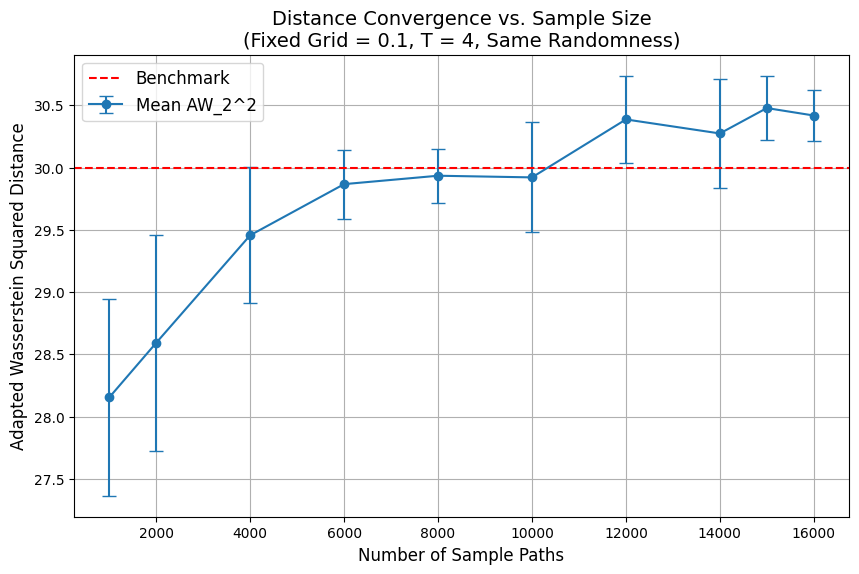

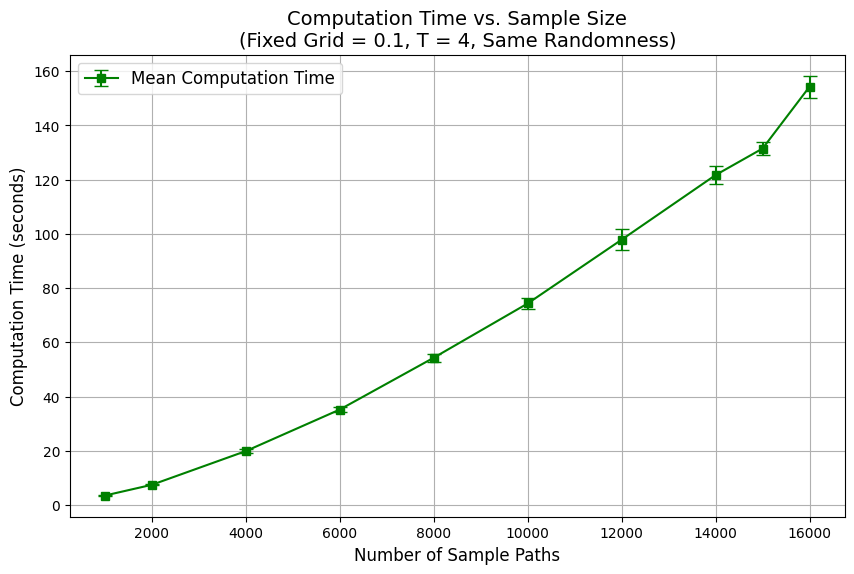

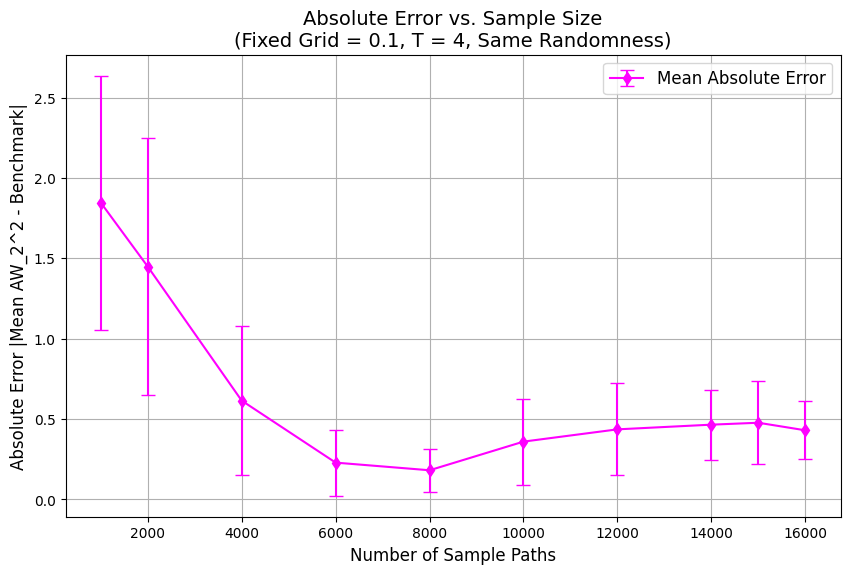

In [4]:
print("\nAggregated Results:")
aggregated = {}
for n_sample in sorted(results.keys()):
    data = results[n_sample]
    dists = data["distances"]
    times = data["times"]
    bench = data["benchmark"]
    mean_dist = np.mean(dists)
    std_dist = np.std(dists)
    mean_time = np.mean(times)
    std_time = np.std(times)
    abs_errors = np.abs(dists - bench)
    mean_abs_err = np.mean(abs_errors)
    std_abs_err = np.std(abs_errors)
    aggregated[n_sample] = {
        "mean_distance": mean_dist,
        "std_distance": std_dist,
        "mean_time": mean_time,
        "std_time": std_time,
        "mean_abs_error": mean_abs_err,
        "std_abs_error": std_abs_err,
        "benchmark": bench
    }
    print(f"Sample Size: {n_sample}")
    print(f"  Mean AW_2^2: {mean_dist:.4f} ± {std_dist:.4f}")
    print(f"  Mean Time: {mean_time:.4f} s ± {std_time:.4f} s")
    print(f"  Mean Absolute Error: {mean_abs_err:.4f} ± {std_abs_err:.4f}")
    print(f"  Benchmark: {bench:.4f}\n")


sample_list = sorted(aggregated.keys())
mean_distances = [aggregated[n]["mean_distance"] for n in sample_list]
std_distances = [aggregated[n]["std_distance"] for n in sample_list]
mean_times = [aggregated[n]["mean_time"] for n in sample_list]
std_times = [aggregated[n]["std_time"] for n in sample_list]
mean_abs_errors = [aggregated[n]["mean_abs_error"] for n in sample_list]
std_abs_errors = [aggregated[n]["std_abs_error"] for n in sample_list]
benchmark = aggregated[sample_list[0]]["benchmark"]  # assuming benchmark is the same across sizes

# Plot 1: Distance Convergence
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_distances, yerr=std_distances, fmt="o-", capsize=5, label="Mean AW_2^2")
plt.axhline(y=benchmark, color="red", linestyle="--", label="Benchmark")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Adapted Wasserstein Squared Distance", fontsize=12)
plt.title("Distance Convergence vs. Sample Size\n(Fixed Grid = 0.1, T = 4, Same Randomness)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 2: Computation Time
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_times, yerr=std_times, fmt="s-", capsize=5, color="green", label="Mean Computation Time")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Computation Time (seconds)", fontsize=12)
plt.title("Computation Time vs. Sample Size\n(Fixed Grid = 0.1, T = 4, Same Randomness)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

# Plot 3: Absolute Error
plt.figure(figsize=(10, 6))
plt.errorbar(sample_list, mean_abs_errors, yerr=std_abs_errors, fmt="d-", capsize=5, color="magenta", label="Mean Absolute Error")
plt.xlabel("Number of Sample Paths", fontsize=12)
plt.ylabel("Absolute Error |Mean AW_2^2 - Benchmark|", fontsize=12)
plt.title("Absolute Error vs. Sample Size\n(Fixed Grid = 0.1, T = 4, Same Randomness)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()
